In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from Bio import SeqIO
from sklearn.cluster import AffinityPropagation, KMeans, DBSCAN
from sklearn.manifold import MDS, t_sne, Isomap
from sklearn.metrics import silhouette_score
from util.isoelectric_point import isoelectric_points
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white')
sns.set_context('notebook')

# Learning Outcomes

By the end of this notebook, you will learn that:

1. Your data have to be structured as a **2D numerical matrix**.
2. Clustering is easily done by using the **`model.fit(X)`** and **`model.predict(X)`** coding pattern.
3. Different algorithms perform differently (accuracy, speed).
4. It is possible to evaluate clustering performance by using the **silhouette score**.

# Problem

If I'm given a list of samples, how do I figure out what samples are similar to one another?

Here, we will explore this problem by using biological sequence data.

The data here are 1000 influenza H1 sequences. Let's see if we can find any interesting structure in this dataset.

**Please uncomment the code the following 3 cells, and run them.**

In [21]:
# Load the sequence data into memory. 
# BioPython is a great Python package for reading and manipulating biological sequence data.
# Remember, though, that the data have to ultimately become a 2D matrix.
sequences = [s for s in SeqIO.parse('data/human_h1_aligned_downsampled.fasta', 'fasta')]
sequences[0:5]

[SeqRecord(seq=Seq('---------MKAKLLVLLCAFTATYADTICIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='CY000449', name='CY000449', description='CY000449', dbxrefs=[]),
 SeqRecord(seq=Seq('---------MKAILVVMLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='CY043094', name='CY043094', description='CY043094', dbxrefs=[]),
 SeqRecord(seq=Seq('---------MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='KC781514', name='KC781514', description='KC781514', dbxrefs=[]),
 SeqRecord(seq=Seq('---------MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='KC891176', name='KC891176', description='KC891176', dbxrefs=[]),
 SeqRecord(seq=Seq('---------MKAILVVLLYTFATANADTLCIGYHANNSTDTVDTVLEKNVTVTH...---', SingleLetterAlphabet()), id='CY063807', name='CY063807', description='CY063807', dbxrefs=[])]

In [22]:
# Get a list of the sequence identifiers. 
seqids = [s.id for s in SeqIO.parse('data/human_h1_aligned_downsampled.fasta', 'fasta')]
seqids[0:5]

['CY000449', 'CY043094', 'KC781514', 'KC891176', 'CY063807']

An important part of using machine learning algorithms is that your data have to be numeric. Strings and special values (`inf` or `NaN`) are not allowed in many of them.

With the sequence data, what could we replace the letters with?

In [25]:
# Make the data into a pandas dataframe, which is an acceptable data input for scikit-learn.
seq_df = pd.DataFrame(sequences)
seq_df.index = seqids
seq_df = seq_df.replace(isoelectric_points.keys(), isoelectric_points.values()).replace('-', 0)
seq_df.head()

,0,1,2,3,4,5,6,7,8,9,...,606,607,608,609,610,611,612,613,614,615
CY000449,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0
CY043094,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0
KC781514,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0
KC891176,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0
CY063807,0,0,0,0,0,0,0,0,0,5.74,...,0,0,0,0,0,0,0,0,0,0


## Coding Pattern

The coding pattern as implemented by the scikit-learn API is as follows:

    model = YourModelHere()
    model.fit(X1)
    model.predict(X2)

In [40]:
# Let's try 
ap = AffinityPropagation()
ap.fit(seq_df)  # trains the clustering algorithm on the seq_df.
ap_cluster_labels = ap.predict(seq_df)

## Visualizing the clustering pattern

In [28]:
# Use multi-dimensional scaling (MDS) to get a 2-D plane representation of the data, so that we can plot it.
mds = MDS()
mds_coords = mds.fit_transform(seq_df)
mds_coords

array([[ 13.20901978, -26.00536746],
       [  4.49721174,   5.80871428],
       [ -3.13450301,  11.15024786],
       ..., 
       [ -3.85901155,  11.38313439],
       [ -5.27129463, -31.31755965],
       [-15.65716791, -25.50274147]])

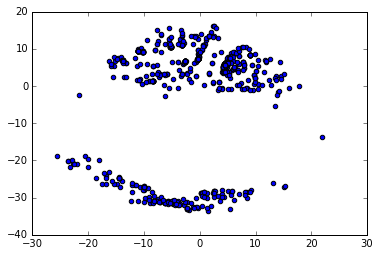

In [29]:
# Let's plot this using matplotlib
plt.scatter(mds_coords[:,0], mds_coords[:,1])

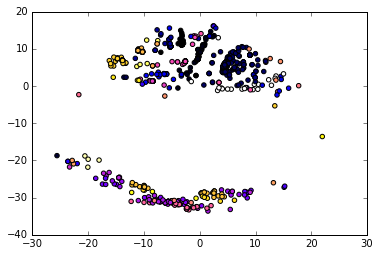

In [31]:
# Colour the clusters by cluster number, then plot on MDS plot.
cmap = plt.cm.get_cmap('gnuplot2', len(ap_cluster_labels))

plt.scatter(mds_coords[:,0], mds_coords[:,1], c=ap_cluster_labels, cmap=cmap)

# Evaluating clustering results

One metric for evaluating clustering results, which is provided by the `scikit-learn` API, is the [`silhouette_score`][1].

The definition of the `silhouette_score` is $ \dfrac{b - a}{max(a, b)} $. The score can take on values between -1 and 1, with -1 being the worst, and +1 being the best scores. 0 indicates overlapping clusters. 

From the `scikit-learn` API documentation:

> The Silhouette Coefficient is calculated using the mean intra-cluster distance **`a`** and the mean nearest-cluster distance **`b`** for each sample. The Silhouette Coefficient for a sample is `(b - a) / max(a, b)`. To clarify, `b` is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficent is only defined if number of labels is 2 <= n_labels <= n_samples - 1.


Chalkboard example: three blobs

[1]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [32]:
silhouette_score(seq_df, ap_cluster_labels)

0.54858013903719594

# Exercises (10 min)

Use K-means to cluster the data. See if you can colour the 2 clusters in an MDS plot.

In [33]:
km = KMeans(n_clusters=2)
km_cluster_labels = km.fit_predict(seq_df)
km_cluster_labels[0:5]

array([0, 1, 1, 1, 1], dtype=int32)

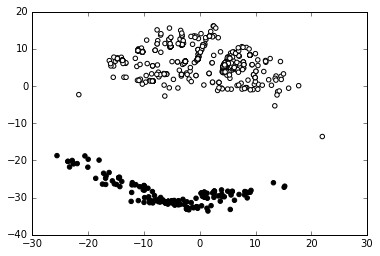

In [34]:
cmap = plt.cm.get_cmap('gnuplot2', len(km_cluster_labels))

plt.scatter(mds_coords[:,0], mds_coords[:,1], c=km_cluster_labels, cmap=cmap)

In [35]:
silhouette_score(seq_df, km_cluster_labels)

0.72874101114084111

For comparison, try the DBSCAN algorithm, and do the same thing.

In [36]:
dbs = DBSCAN()
dbs_cluster_labels = dbs.fit_predict(seq_df)
dbs_cluster_labels[0:5]

array([-1,  0,  1, -1,  2])

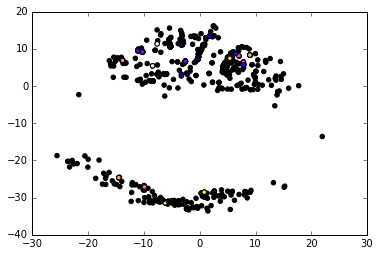

In [37]:
cmap = plt.cm.get_cmap('gnuplot2', len(dbs_cluster_labels))

plt.scatter(mds_coords[:,0], mds_coords[:,1], c=dbs_cluster_labels, cmap=cmap)

In [38]:
# What are the silhouette scores for each of the 3 algorithms?
silhouette_score(seq_df, dbs_cluster_labels)

0.098712808778024685

Try one other clustering algorithm, listed [here][1], and evaluate its performance.

[1]: http://scikit-learn.org/stable/modules/clustering.html

# Comparison of Clustering Algorithms

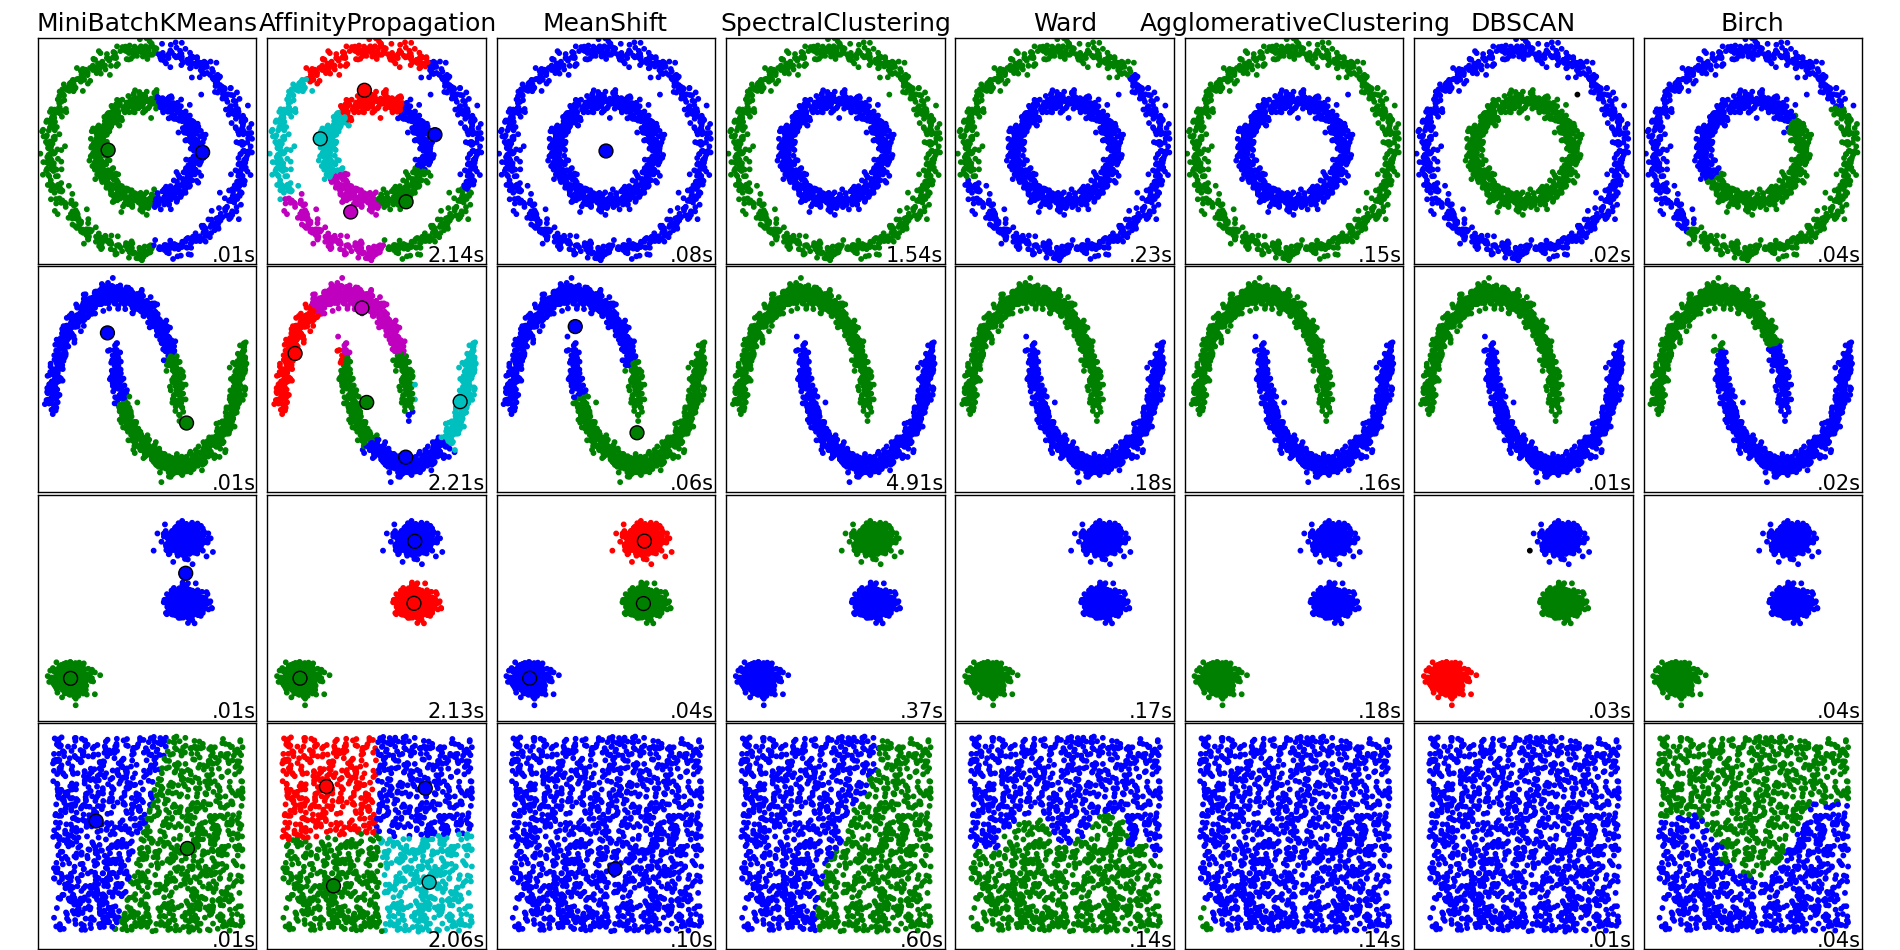

In [43]:
Image('http://scikit-learn.org/stable/_images/plot_cluster_comparison_001.png')

# Takeaways

1. Clustering: It's all about figuring out what samples are similar to one another.
    * `clusterer.fit_predict(data)`
1. Manifold Learning: It's all about finding a low-dimensional representation of high-dimensional data.
    * `manifold.fit_transform(data)`
1. Evaluation: Check how good the clustering is by using metrics available in the `sklearn.metrics` module.